In [1]:
import os
import pandas
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import isingmodellight
from isingmodellight import IsingModelLight
from scipy import stats
import time
import hcpdatautils as hcp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
int_type = torch.int
float_type = torch.float
device = torch.device('cuda')

In [3]:
file_dir = 'E:\\Ising_model_results_daai'
other_file_dir = 'D:\\Ising_model_results_daai'

In [4]:
training_subject_start=0
training_subject_end = 670

In [5]:
def depytorch(t:torch.Tensor):
    return t.detach().cpu().numpy()

In [6]:
def make_histogram(name:str, values:torch.Tensor):
    fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(9, 6) )
    axs.hist(  depytorch( values.flatten() )  )
    # axs.set_xticklabels( axs.get_xticklabels(), rotation=90, ha='right' )
    axs.set_xlabel(name)
    axs.set_ylabel('count in bin')
    axs.set_title(f'distribution of {name}')
    plt.show()

In [7]:
def print_stats(name:str, values:torch.Tensor):
    values = values.flatten()
    quantile_cutoffs = torch.tensor([0.025, 0.5, 0.975], dtype=float_type, device=device)
    quantiles = torch.quantile(values, quantile_cutoffs)
    min_val = torch.min(values)
    max_val = torch.max(values)
    print(f'The distribution of {name} values has median {quantiles[1].item():.3g} with 95% CI [{quantiles[0].item():.3g}, {quantiles[2].item():.3g}] and range [{min_val.item():.3g}, {max_val.item():.3g}].')

In [8]:
def get_closest_match(values:torch.Tensor, target:float):
    return torch.argmin( torch.abs(values - target) )

In [9]:
plt.rcParams.update({'font.size': 20})

In [10]:
example_ts = torch.load( os.path.join(other_file_dir, 'data_ts_all_as_is.pt'), weights_only=False )[:,0,:,:].transpose(dim0=0, dim1=1).flatten(start_dim=-2,end_dim=-1)
print( example_ts.size() )

torch.Size([360, 4800])


original cov range [-0.273, 1]
original FC range [-0.273, 1]
threshold=0 cov range [-0.347, 1]
threshold=0 FC range [-0.348, 0.998]
threshold=1 cov range [-0.132, 0.69]
threshold=1 FC range [-0.222, 0.998]
threshold=1.6 cov range [-0.0389, 0.412]
threshold=1.6 FC range [nan, nan]


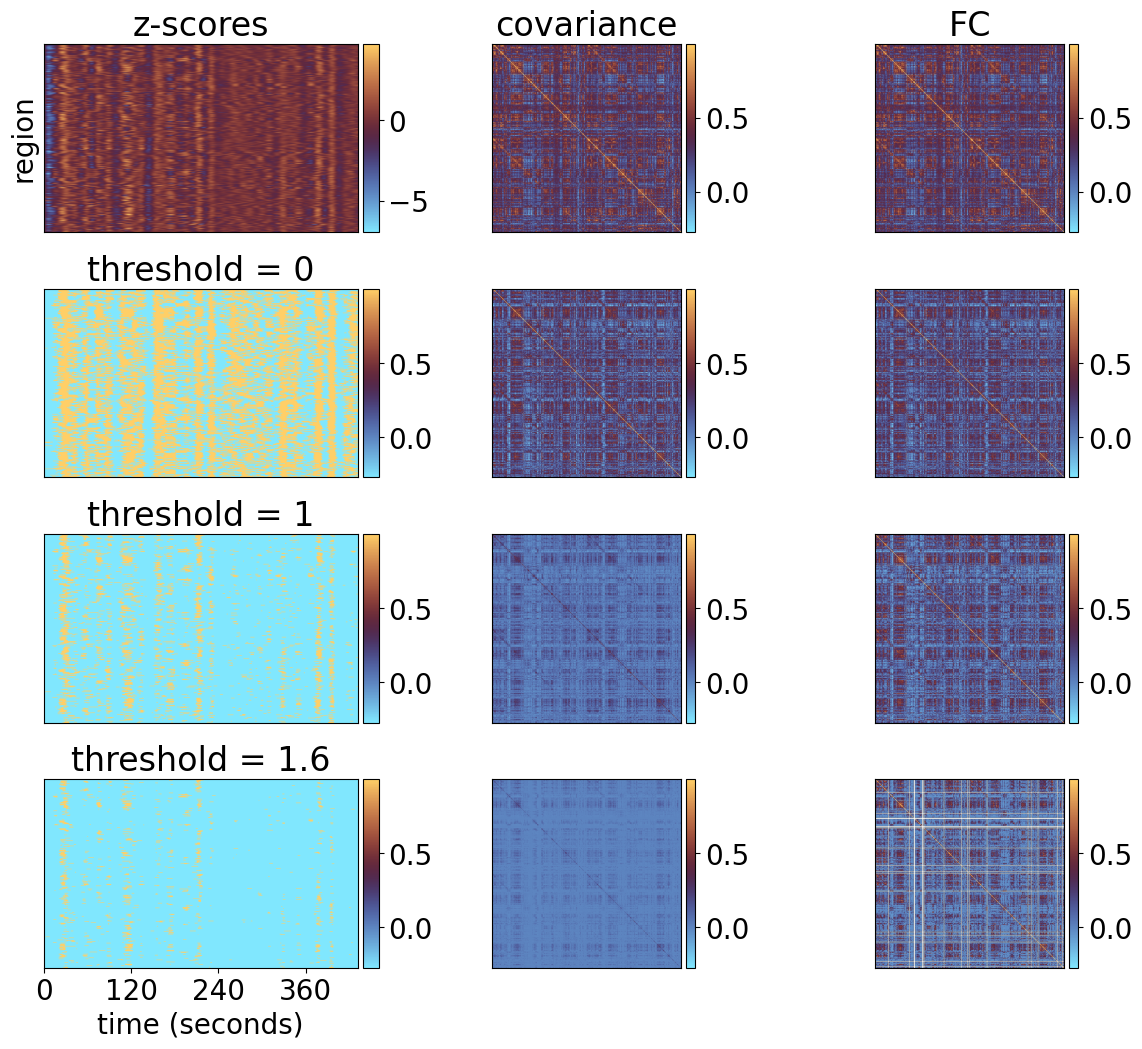

In [11]:
def get_cov(ts:torch.Tensor):
    ts_std, ts_mean = torch.std_mean(ts, dim=-1, keepdim=False)
    return (  torch.matmul( ts, ts.transpose(dim0=0, dim1=1) )/ts.size(dim=-1) - ts_mean.unsqueeze(dim=1) * ts_mean.unsqueeze(dim=0)  )

def get_fc(ts:torch.Tensor):
    ts_std, ts_mean = torch.std_mean(ts, dim=-1, keepdim=False)
    return (  torch.matmul( ts, ts.transpose(dim0=0, dim1=1) )/ts.size(dim=-1) - ts_mean.unsqueeze(dim=1) * ts_mean.unsqueeze(dim=0)  )/( ts_std.unsqueeze(dim=1) * ts_std.unsqueeze(dim=0) )

fig, axs = plt.subplots( nrows=4, ncols=3, figsize=(24, 12) )

max_time_index = 600

data_std, data_mean = torch.std_mean(example_ts, dim=-1, keepdim=True)
data_z = (example_ts - data_mean)/data_std
# Plot the unbinarized time series.
data_z_to_plot = data_z[:,:max_time_index]
max_abs = torch.max( torch.abs(data_z_to_plot) )
# cmap = 'berlin_r'
# cmap = 'bwr_r'
cmap = 'managua_r'
# cmap = 'vanimo'
# cmap = 'coolwarm_r'
# cmap = 'Spectral'
# cmap = 'seismic_r'

shown_image = axs[0,0].imshow( depytorch(data_z_to_plot), cmap=cmap )
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shown_image, cax=cax, orientation='vertical')
axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].set_ylabel('region')
axs[0,0].set_title('z-scores')
axs[0,0].set_anchor('W')

# Plot the covariance of the unbinarized data.
cov_original = get_cov(data_z)
shown_image = axs[0,1].imshow( depytorch(cov_original), cmap=cmap ) 
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shown_image, cax=cax, orientation='vertical')
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])
axs[0,1].set_title('covariance')
# axs[0,1].set_title('cov.')
print(f'original cov range [{cov_original.min():.3g}, {cov_original.max():.3g}]')
axs[0,1].set_anchor('W')

# Plot the FC of the unbinarized data.
fc_original = get_fc(data_z)
shown_image = axs[0,2].imshow( depytorch(fc_original), cmap=cmap )
divider = make_axes_locatable(axs[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shown_image, cax=cax, orientation='vertical')
axs[0,2].set_xticks([])
axs[0,2].set_yticks([])
axs[0,2].set_title('FC')
print(f'original FC range [{fc_original.min():.3g}, {fc_original.max():.3g}]')
axs[0,2].set_anchor('W')

cov_min = cov_original.min().item()
cov_max = cov_original.max().item()

fc_min = fc_original.min().item()
fc_max = fc_original.max().item()

for threshold, row_index in zip([0.0, 1.0, 1.6],[1, 2, 3]):
    # Plot the binarized time series.
    binarized_ts = 2.0*(data_z_to_plot >= threshold).float() - 1.0
    axs[row_index,0].imshow( depytorch(binarized_ts), cmap=cmap, vmin=-1.0, vmax=1.0 )
    divider = make_axes_locatable(axs[row_index,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(shown_image, cax=cax, orientation='vertical')
    axs[row_index,0].set_xticks([])
    axs[row_index,0].set_yticks([])
    axs[row_index,0].set_title(f'threshold = {threshold:.3g}')
    # Plot the covariance of the binarized time series.
    binarized_cov = get_cov(binarized_ts)
    shown_image = axs[row_index,1].imshow( depytorch(binarized_cov), cmap=cmap , vmin=cov_min, vmax=cov_max )
    axs[row_index,0].set_anchor('W')
    divider = make_axes_locatable(axs[row_index,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(shown_image, cax=cax, orientation='vertical')
    axs[row_index,1].set_xticks([])
    axs[row_index,1].set_yticks([])
    print(f'threshold={threshold:.3g} cov range [{binarized_cov.min():.3g}, {binarized_cov.max():.3g}]')
    axs[row_index,1].set_anchor('W')
    # Plot the FC of the binarized time series.
    binarized_fc = get_fc(binarized_ts)
    shown_image = axs[row_index,2].imshow( depytorch(binarized_fc), cmap=cmap, vmin=fc_min, vmax=fc_max )
    divider = make_axes_locatable(axs[row_index,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(shown_image, cax=cax, orientation='vertical')
    axs[row_index,2].set_xticks([])
    axs[row_index,2].set_yticks([])
    print(f'threshold={threshold:.3g} FC range [{binarized_fc.min():.3g}, {binarized_fc.max():.3g}]')
    axs[row_index,2].set_anchor('W')

seconds_per_index = 0.72
seconds_per_tick = 120
tick_time_indices = torch.arange( start=0.0, end=float(max_time_index), step=seconds_per_tick/seconds_per_index, dtype=float_type, device=device )
tick_times = tick_time_indices * seconds_per_index
axs[3,0].set_xticks( depytorch(tick_time_indices) )
axs[3,0].set_xticklabels([ f'{t:.3g}' for t in tick_times ]) 
axs[3,0].set_xlabel('time (seconds)')

# fig.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=-0.65)
plt.show()

original cov range [-0.273, 1]
original FC range [-0.273, 1]
threshold=0 cov range [-0.347, 1]
threshold=0 FC range [-0.348, 0.998]
threshold=1 cov range [-0.132, 0.69]
threshold=1 FC range [-0.222, 0.998]
threshold=1.6 cov range [-0.0389, 0.412]
threshold=1.6 FC range [nan, nan]


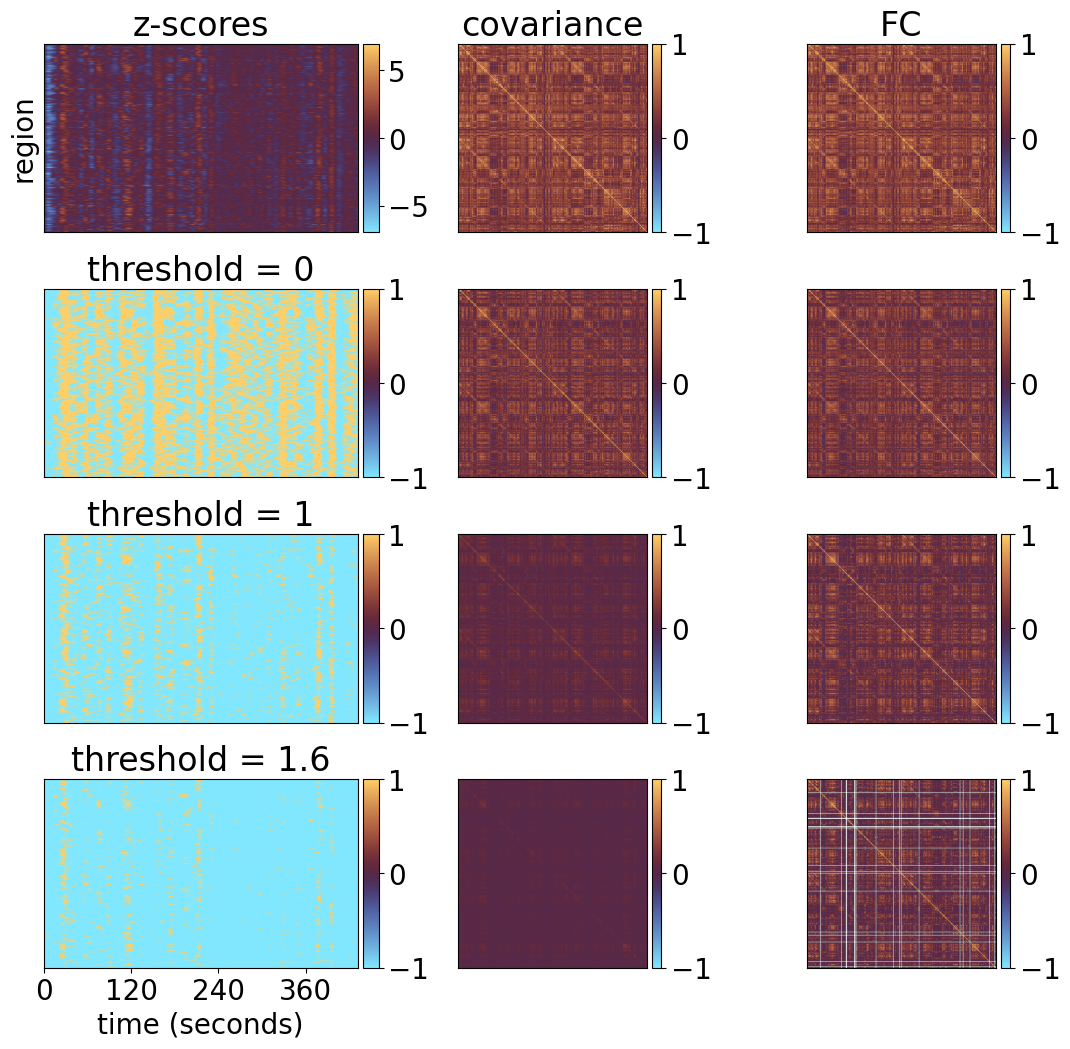

In [12]:
def get_cov(ts:torch.Tensor):
    ts_std, ts_mean = torch.std_mean(ts, dim=-1, keepdim=False)
    return (  torch.matmul( ts, ts.transpose(dim0=0, dim1=1) )/ts.size(dim=-1) - ts_mean.unsqueeze(dim=1) * ts_mean.unsqueeze(dim=0)  )

def get_fc(ts:torch.Tensor):
    ts_std, ts_mean = torch.std_mean(ts, dim=-1, keepdim=False)
    return (  torch.matmul( ts, ts.transpose(dim0=0, dim1=1) )/ts.size(dim=-1) - ts_mean.unsqueeze(dim=1) * ts_mean.unsqueeze(dim=0)  )/( ts_std.unsqueeze(dim=1) * ts_std.unsqueeze(dim=0) )

fig, axs = plt.subplots( nrows=4, ncols=3, figsize=(24, 12) )

max_time_index = 600

data_std, data_mean = torch.std_mean(example_ts, dim=-1, keepdim=True)
data_z = (example_ts - data_mean)/data_std
# Plot the unbinarized time series.
data_z_to_plot = data_z[:,:max_time_index]
max_abs = torch.max( torch.abs(data_z_to_plot) )
# cmap = 'berlin_r'
# cmap = 'bwr_r'
cmap = 'managua_r'
# cmap = 'vanimo'
# cmap = 'coolwarm_r'
# cmap = 'Spectral'
# cmap = 'seismic_r'

shown_image = axs[0,0].imshow( depytorch(data_z_to_plot), cmap=cmap, vmin=-max_abs, vmax=max_abs )
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shown_image, cax=cax, orientation='vertical')
axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].set_ylabel('region')
axs[0,0].set_title('z-scores')

# Plot the covariance of the unbinarized data.
cov_original = get_cov(data_z)
shown_image = axs[0,1].imshow( depytorch(cov_original), cmap=cmap, vmin=-1, vmax=1 ) 
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shown_image, cax=cax, orientation='vertical')
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])
axs[0,1].set_title('covariance')
print(f'original cov range [{cov_original.min():.3g}, {cov_original.max():.3g}]')

# Plot the FC of the unbinarized data.
fc_original = get_fc(data_z)
shown_image = axs[0,2].imshow( depytorch(fc_original), cmap=cmap, vmin=-1, vmax=1 )
divider = make_axes_locatable(axs[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shown_image, cax=cax, orientation='vertical')
axs[0,2].set_xticks([])
axs[0,2].set_yticks([])
axs[0,2].set_title('FC')
print(f'original FC range [{fc_original.min():.3g}, {fc_original.max():.3g}]')

for threshold, row_index in zip([0.0, 1.0, 1.6],[1, 2, 3]):
    # Plot the binarized time series.
    binarized_ts = 2.0*(data_z_to_plot >= threshold).float() - 1.0
    axs[row_index,0].imshow( depytorch(binarized_ts), cmap=cmap, vmin=-1.0, vmax=1.0 )
    divider = make_axes_locatable(axs[row_index,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(shown_image, cax=cax, orientation='vertical')
    axs[row_index,0].set_xticks([])
    axs[row_index,0].set_yticks([])
    axs[row_index,0].set_title(f'threshold = {threshold:.3g}')
    # Plot the covariance of the binarized time series.
    binarized_cov = get_cov(binarized_ts)
    shown_image = axs[row_index,1].imshow( depytorch(binarized_cov), cmap=cmap , vmin=-1, vmax=1 )
    divider = make_axes_locatable(axs[row_index,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(shown_image, cax=cax, orientation='vertical')
    axs[row_index,1].set_xticks([])
    axs[row_index,1].set_yticks([])
    print(f'threshold={threshold:.3g} cov range [{binarized_cov.min():.3g}, {binarized_cov.max():.3g}]')
    # axs[row_index,1].set_anchor('W')
    # Plot the FC of the binarized time series.
    binarized_fc = get_fc(binarized_ts)
    shown_image = axs[row_index,2].imshow( depytorch(binarized_fc), cmap=cmap, vmin=-1, vmax=1 )
    divider = make_axes_locatable(axs[row_index,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(shown_image, cax=cax, orientation='vertical')
    axs[row_index,2].set_xticks([])
    axs[row_index,2].set_yticks([])
    print(f'threshold={threshold:.3g} FC range [{binarized_fc.min():.3g}, {binarized_fc.max():.3g}]')
    # axs[row_index,2].set_anchor('W')

seconds_per_index = 0.72
seconds_per_tick = 120
tick_time_indices = torch.arange( start=0.0, end=float(max_time_index), step=seconds_per_tick/seconds_per_index, dtype=float_type, device=device )
tick_times = tick_time_indices * seconds_per_index
axs[3,0].set_xticks( depytorch(tick_time_indices) )
axs[3,0].set_xticklabels([ f'{t:.3g}' for t in tick_times ]) 
axs[3,0].set_xlabel('time (seconds)')

# fig.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=-0.7)
plt.show()

original cov range [-0.273, 1]
original FC range [-0.273, 1]
threshold=0 cov range [-0.175, 1]
threshold=0 FC range [-0.175, 1]
threshold=1 cov range [-0.0572, 0.554]
threshold=1 FC range [-0.128, 1]
threshold=1.6 cov range [-0.0133, 0.247]
threshold=1.6 FC range [-0.0612, 1]


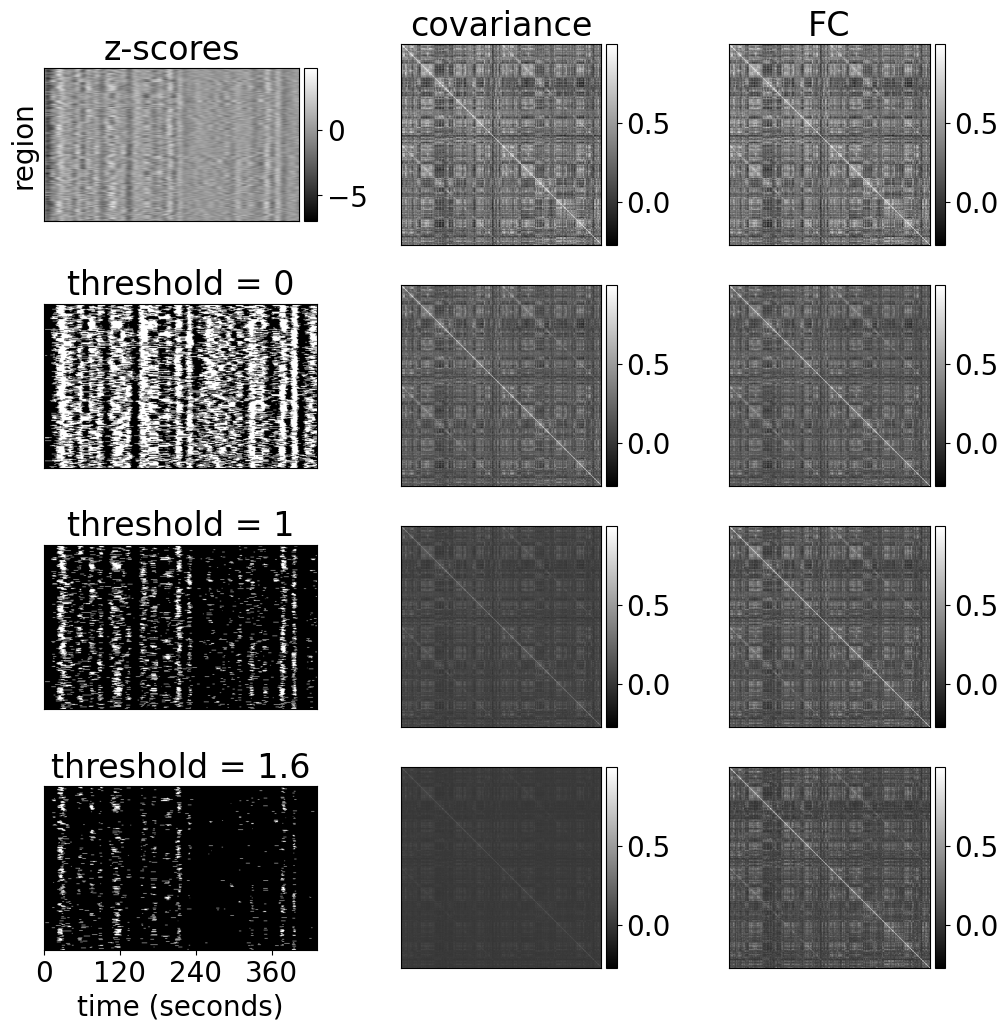

In [13]:
max_time_index = 600

data_std, data_mean = torch.std_mean(example_ts, dim=-1, keepdim=True)
data_z = (example_ts - data_mean)/data_std
# Plot the unbinarized time series.
data_z_to_plot = data_z[:,:max_time_index]
max_abs = torch.max( torch.abs(data_z_to_plot) )

fig, axs = plt.subplots( nrows=4, ncols=3, figsize=(12, 12) )

# cmap = 'berlin_r'
# cmap = 'bwr_r'
# cmap = 'managua_r'
# cmap = 'vanimo'
# cmap = 'coolwarm_r'
# cmap = 'Spectral'
# cmap = 'seismic_r'
cmap = 'gray'

shown_image = axs[0,0].imshow( depytorch(data_z_to_plot), cmap=cmap )
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shown_image, cax=cax, orientation='vertical')
axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].set_ylabel('region')
axs[0,0].set_title('z-scores')
axs[0,0].set_anchor('W')

# Plot the covariance of the unbinarized data.
cov_original = get_cov(data_z)
shown_image = axs[0,1].imshow( depytorch(cov_original), cmap=cmap ) 
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shown_image, cax=cax, orientation='vertical')
axs[0,1].set_xticks([])
axs[0,1].set_yticks([])
axs[0,1].set_title('covariance')
# axs[0,1].set_title('cov.')
print(f'original cov range [{cov_original.min():.3g}, {cov_original.max():.3g}]')
axs[0,1].set_anchor('W')

# Plot the FC of the unbinarized data.
fc_original = get_fc(data_z)
shown_image = axs[0,2].imshow( depytorch(fc_original), cmap=cmap )
divider = make_axes_locatable(axs[0,2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(shown_image, cax=cax, orientation='vertical')
axs[0,2].set_xticks([])
axs[0,2].set_yticks([])
axs[0,2].set_title('FC')
print(f'original FC range [{fc_original.min():.3g}, {fc_original.max():.3g}]')
axs[0,2].set_anchor('W')

cov_min = cov_original.min().item()
cov_max = cov_original.max().item()

fc_min = fc_original.min().item()
fc_max = fc_original.max().item()

for threshold, row_index in zip([0.0, 1.0, 1.6],[1, 2, 3]):
    # Plot the binarized time series.
    binarized_ts = 2.0*(data_z >= threshold).float() - 1.0
    axs[row_index,0].imshow( depytorch(binarized_ts[:,:max_time_index]), cmap=cmap, vmin=-1.0, vmax=1.0 )
    divider = make_axes_locatable(axs[row_index,0])
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    # fig.colorbar(shown_image, cax=cax, orientation='vertical')
    axs[row_index,0].set_xticks([])
    axs[row_index,0].set_yticks([])
    axs[row_index,0].set_title(f'threshold = {threshold:.3g}')
    # Plot the covariance of the binarized time series.
    binarized_cov = get_cov(binarized_ts)
    shown_image = axs[row_index,1].imshow( depytorch(binarized_cov), cmap=cmap , vmin=cov_min, vmax=cov_max )
    axs[row_index,0].set_anchor('W')
    divider = make_axes_locatable(axs[row_index,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(shown_image, cax=cax, orientation='vertical')
    axs[row_index,1].set_xticks([])
    axs[row_index,1].set_yticks([])
    print(f'threshold={threshold:.3g} cov range [{binarized_cov.min():.3g}, {binarized_cov.max():.3g}]')
    axs[row_index,1].set_anchor('W')
    # Plot the FC of the binarized time series.
    binarized_fc = get_fc(binarized_ts)
    shown_image = axs[row_index,2].imshow( depytorch(binarized_fc), cmap=cmap, vmin=fc_min, vmax=fc_max )
    divider = make_axes_locatable(axs[row_index,2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(shown_image, cax=cax, orientation='vertical')
    axs[row_index,2].set_xticks([])
    axs[row_index,2].set_yticks([])
    print(f'threshold={threshold:.3g} FC range [{binarized_fc.min():.3g}, {binarized_fc.max():.3g}]')
    axs[row_index,2].set_anchor('W')

seconds_per_index = 0.72
seconds_per_tick = 120
tick_time_indices = torch.arange( start=0.0, end=float(max_time_index), step=seconds_per_tick/seconds_per_index, dtype=float_type, device=device )
tick_times = tick_time_indices * seconds_per_index
axs[3,0].set_xticks( depytorch(tick_time_indices) )
axs[3,0].set_xticklabels([ f'{t:.3g}' for t in tick_times ]) 
axs[3,0].set_xlabel('time (seconds)')

# fig.tight_layout()
# plt.subplots_adjust(hspace=0.3, wspace=-0.65)
plt.show()

In [14]:
num_nodes = fc_original.size(dim=-1)
triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products(num_nodes=num_nodes, device=fc_original.device)
print( fc_original.size() )
mean_original, mean_product_original = isingmodellight.get_time_series_mean(time_series=data_z)
cov_original_flat = isingmodellight.get_cov(state_mean=mean_original, state_product_mean=mean_product_original)[triu_rows,triu_cols]
fc_original_flat = isingmodellight.get_fc(state_mean=mean_original, state_product_mean=mean_product_original, epsilon=0.0)[triu_rows,triu_cols]
num_pairs = fc_original_flat.size(dim=-1)
selected_thresholds = [0.0, 1.0, 1.6]
num_selected_thresholds = len(selected_thresholds)
cov_flat_comparison = cov_original_flat.unsqueeze(dim=0).repeat( (num_selected_thresholds+1,1) )
fc_flat_comparison = fc_original_flat.unsqueeze(dim=0).repeat( (num_selected_thresholds+1,1) )
for threshold_index in range(num_selected_thresholds):
    binarized_ts = 2.0*(data_z >= selected_thresholds[threshold_index]).float() - 1.0
    mean_binarized, mean_product_binarized = isingmodellight.get_time_series_mean(time_series=binarized_ts)
    cov_flat_comparison[threshold_index+1,:] = isingmodellight.get_cov(state_mean=mean_binarized, state_product_mean=mean_product_binarized)[triu_rows,triu_cols]
    fc_flat_comparison[threshold_index+1,:] = isingmodellight.get_fc(state_mean=mean_binarized, state_product_mean=mean_product_binarized, epsilon=0.0)[triu_rows,triu_cols]

torch.Size([360, 360])


In [15]:
selected_pairs = torch.linspace(start=0, end=num_pairs-1, steps=20, dtype=float_type, device=cov_flat_comparison.device).int()
print( selected_pairs.numel(), selected_pairs[-1].item() )
cov_sort_indices = torch.sort(cov_original_flat, descending=True).indices
cov_comparison_sorted = cov_flat_comparison[:,cov_sort_indices]
cov_comparison_selected = cov_comparison_sorted[:,selected_pairs]

20 64619


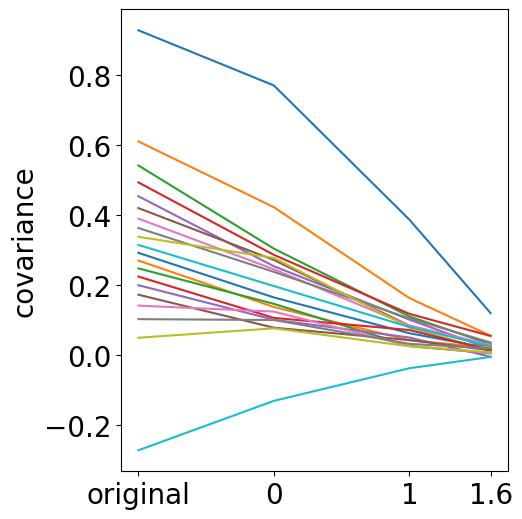

In [16]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 6) )
tick_locations = [-1]+selected_thresholds
axs.plot( tick_locations, depytorch(cov_comparison_selected) )
axs.set_xticks(tick_locations)
axs.set_xticklabels(['original'] + [ f'{t:.3g}' for t in selected_thresholds ]) 
axs.set_ylabel('covariance')
plt.show()

In [17]:
fc_sort_indices = torch.sort(fc_original_flat, descending=True).indices
fc_comparison_sorted = fc_flat_comparison[:,fc_sort_indices]
fc_comparison_selected = fc_comparison_sorted[:,selected_pairs]

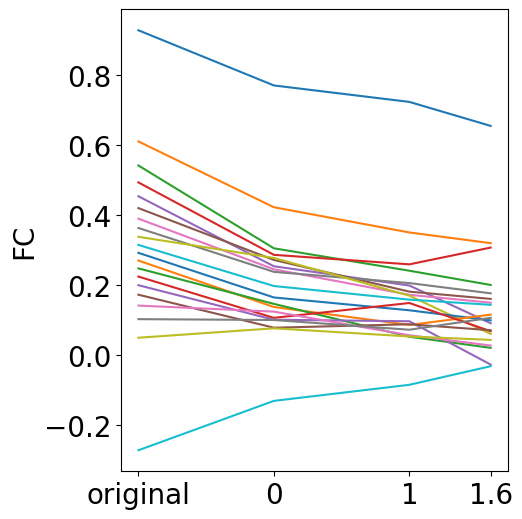

In [18]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5, 6) )
axs.plot( tick_locations, depytorch(fc_comparison_selected) )
axs.set_xticks(tick_locations)
axs.set_xticklabels(['original'] + [ f'{t:.3g}' for t in selected_thresholds ]) 
axs.set_ylabel('FC')
plt.show()

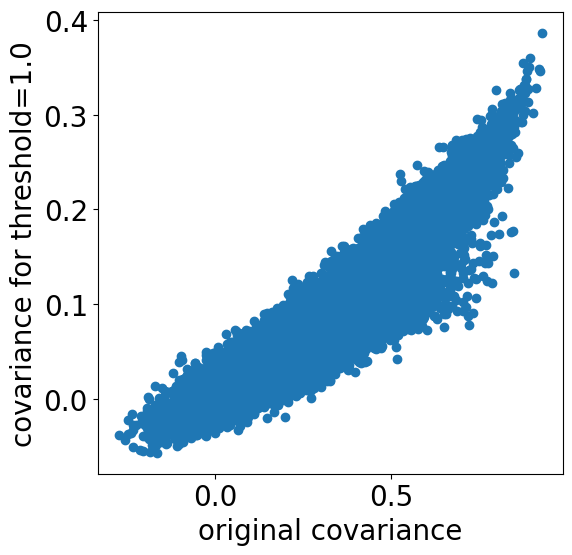

In [19]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 6) )
threshold_index = 1
axs.scatter( depytorch(cov_flat_comparison[0,:]), depytorch(cov_flat_comparison[threshold_index+1,:]) )
axs.set_xlabel('original covariance')
axs.set_ylabel(f'covariance for threshold={selected_thresholds[threshold_index]}')
plt.show()

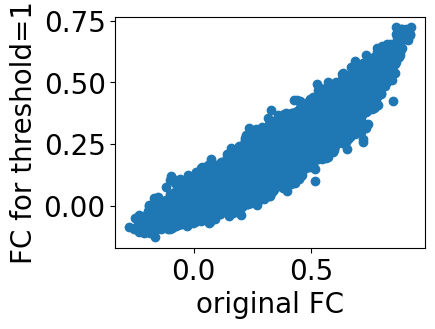

In [26]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(4, 3) )
threshold_index = 1
axs.scatter( depytorch(fc_flat_comparison[0,:]), depytorch(fc_flat_comparison[threshold_index+1,:]) )
axs.set_xlabel('original FC')
axs.set_ylabel(f'FC for threshold={selected_thresholds[threshold_index]:.3g}')
plt.show()

In [22]:
print( isingmodellight.get_pairwise_correlation(mat1=fc_flat_comparison[0,:], mat2=fc_flat_comparison[threshold_index+1,:], epsilon=0.0, dim=-1).item() )

0.9290503859519958


In [45]:
mean_state_as_is = torch.load( os.path.join(file_dir, 'mean_state_all_as_is.pt'), weights_only=False )
print( mean_state_as_is.size() )
mean_state_product_as_is = torch.load( os.path.join(file_dir, 'mean_state_product_all_as_is.pt'), weights_only=False )
print( mean_state_product_as_is.size() )
mean_state_binarized = torch.load( os.path.join(other_file_dir, 'mean_state_all_mean_std_1.pt'), weights_only=False )
print( mean_state_binarized.size() )
mean_state_product_binarized = torch.load( os.path.join(other_file_dir, 'mean_state_product_all_mean_std_1.pt'), weights_only=False )
print( mean_state_product_binarized.size() )

torch.Size([4, 837, 360])
torch.Size([4, 837, 360, 360])
torch.Size([4, 837, 360])
torch.Size([4, 837, 360, 360])


In [46]:
group_mean_state_as_is = mean_state_as_is.mean( dim=(0,1) )
group_mean_state_product_as_is = mean_state_product_as_is.mean( dim=(0,1) )
group_fc_as_is = isingmodellight.get_fc(state_mean=group_mean_state_as_is, state_product_mean=group_mean_state_product_as_is, epsilon=0.0)
print( group_fc_as_is.size() )
group_fc_as_is_flat = group_fc_as_is[triu_rows,triu_cols]
print( group_fc_as_is_flat.size() )
group_mean_state_binarized = mean_state_binarized.mean( dim=(0,1) )
group_mean_state_product_binarized = mean_state_product_binarized.mean( dim=(0,1) )
group_fc_binarized = isingmodellight.get_fc(state_mean=group_mean_state_binarized, state_product_mean=group_mean_state_product_binarized, epsilon=0.0)
print( group_fc_binarized.size() )
group_fc_binarized_flat = group_fc_binarized[triu_rows,triu_cols]
print( group_fc_binarized_flat.size() )

torch.Size([360, 360])
torch.Size([64620])
torch.Size([360, 360])
torch.Size([64620])


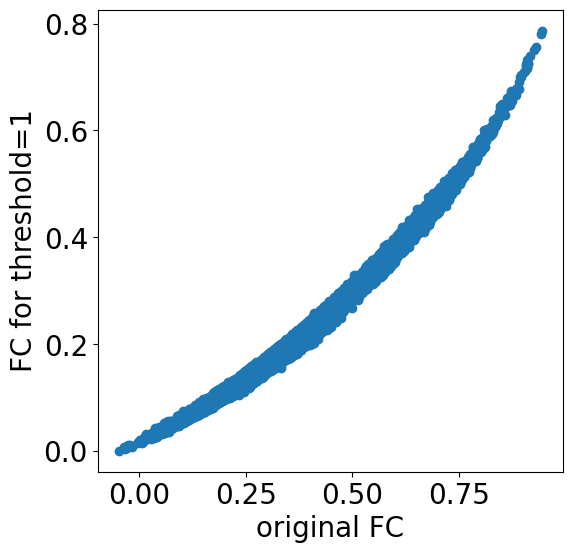

In [47]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 6) )
threshold_index = 1
axs.scatter( depytorch(group_fc_as_is_flat), depytorch(group_fc_binarized_flat) )
axs.set_xlabel('original FC')
axs.set_ylabel(f'FC for threshold=1')
plt.show()

In [51]:
print( isingmodellight.get_pairwise_correlation(mat1=group_fc_as_is_flat, mat2=group_fc_binarized_flat, epsilon=0.0, dim=-1).item() )

0.9911068081855774


In [101]:
all_ts = torch.load( os.path.join(other_file_dir, 'data_ts_all_as_is.pt'), weights_only=False ).transpose(dim0=0, dim1=2).flatten(start_dim=-2,end_dim=-1)
print( all_ts.size() )

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.39 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 8.67 GiB is allocated by PyTorch, and 5.40 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
min_threshold = 0.0
max_threshold = 3.0
num_thresholds = 31
thresholds = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=all_ts.dtype, device=all_ts.device)

In [ ]:
all_std, all_mean = torch.std_mean(all_ts, dim=-1)
all_ts -= all_mean
all_ts /= all_std

In [ ]:
all_mean, all_mean_product = isingmodellight.get_time_series_mean_step_by_step(time_series=all_ts)

In [52]:
num_thresholds = 121
min_threshold = -6.0
max_threshold = 6.0
as_is_vs_binarized_data_string = f'data_ts_training_vs_binarized_thresholds_{num_thresholds}_min_{min_threshold:.3g}_max_{max_threshold:.3g}'

In [61]:
print( os.path.join(other_file_dir, f'fc_corr_{as_is_vs_binarized_data_string}.pt') )

D:\Ising_model_results_daai\fc_corr_data_ts_training_vs_binarized_thresholds_121_min_-6_max_6.pt


In [53]:
fc_corr = torch.load( os.path.join(other_file_dir, f'fc_corr_{as_is_vs_binarized_data_string}.pt'), weights_only=False )
print( 'fc_corr size', fc_corr.size() )
group_fc_corr = torch.load( os.path.join(other_file_dir, f'group_fc_corr_{as_is_vs_binarized_data_string}.pt'), weights_only=False )
print( 'group_fc_corr size', group_fc_corr.size() )

fc_corr size torch.Size([121, 670])
group_fc_corr size torch.Size([121])


In [54]:
def get_med_and_ci(values:torch.Tensor):
    thresholds_dim = 0
    instances_dim = 1
    quantiles = torch.tensor(data=[0.025, 0.975, 0.5], dtype=values.dtype, device=values.device)
    num_quantiles = quantiles.numel()
    num_thresholds = values.size(dim=thresholds_dim)
    quant_vals = torch.zeros( size=(num_quantiles, num_thresholds), dtype=values.dtype, device=values.device )
    for threshold_index in range(num_thresholds):
        vals_at_threshold = values[threshold_index,:]
        is_not_nan = torch.logical_not( torch.isnan(vals_at_threshold) )
        if torch.any(is_not_nan):
            not_nan_vals = vals_at_threshold[is_not_nan]
            quant_vals[:,threshold_index] = torch.quantile(input=not_nan_vals, q=quantiles)
    med = quant_vals[-1,:]
    ci = torch.abs( quant_vals[:-1,:] - med.unsqueeze(dim=0) )
    return med, ci

In [55]:
thresholds = torch.linspace(start=min_threshold, end=max_threshold, steps=num_thresholds, dtype=fc_corr.dtype, device=fc_corr.device)
fc_corr_med, fc_corr_ci = get_med_and_ci(values=fc_corr)
print( 'fc_corr_ci size', fc_corr_ci.size() )

fc_corr_ci size torch.Size([2, 121])


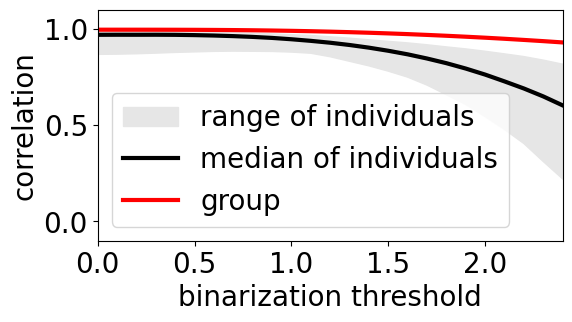

In [56]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 3) )
thresholds_np = depytorch(thresholds)
subject_dim = -1
line_width = 3.0
min_fc_corr = depytorch( torch.min(fc_corr, dim=subject_dim).values )
max_fc_corr = depytorch( torch.max(fc_corr, dim=subject_dim).values )
median_fc_corr = depytorch( torch.median(fc_corr, dim=subject_dim).values )
group_fc_corr_np = depytorch(group_fc_corr)
axs.fill_between(thresholds_np, min_fc_corr, max_fc_corr, color=[0.9, 0.9, 0.9], label='range of individuals')
# axs.plot(thresholds_np, min_fc_corr, color='black', linestyle='--', linewidth=line_width)
# axs.plot(thresholds_np, max_fc_corr, color='black', linestyle='--', linewidth=line_width)
axs.plot(thresholds_np, median_fc_corr, color='black', label='median of individuals', linewidth=line_width)
axs.plot(thresholds_np, group_fc_corr_np, color='red', label='group', linewidth=line_width)
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
axs.set_xlim([0, 2.4])
axs.set_ylim([-0.1, 1.1])
axs.legend(loc='lower left')
plt.show()

In [60]:
thresh_index = get_closest_match(values=thresholds, target=1.0)
print( fc_corr.size(), fc_corr[thresh_index,:].min().item(), fc_corr[thresh_index,:].max().item() )

torch.Size([121, 670]) 0.8799527287483215 0.9703192710876465


In [62]:
print( fc_corr[thresh_index,0].item() )

0.9329487085342407


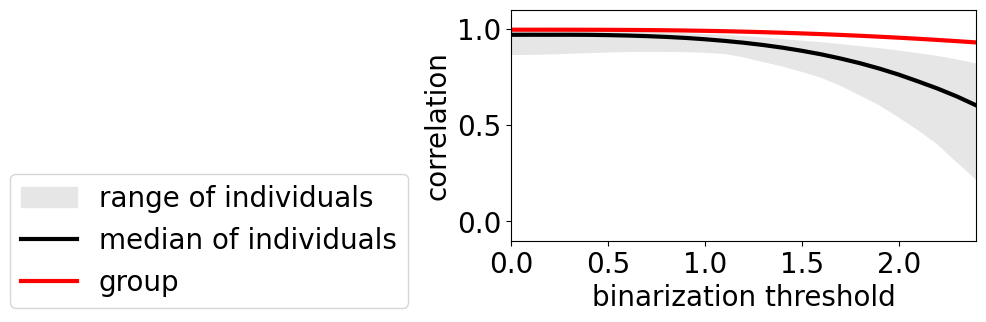

In [18]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6, 3) )
thresholds_np = depytorch(thresholds)
subject_dim = -1
line_width = 3.0
min_fc_corr = depytorch( torch.min(fc_corr, dim=subject_dim).values )
max_fc_corr = depytorch( torch.max(fc_corr, dim=subject_dim).values )
median_fc_corr = depytorch( torch.median(fc_corr, dim=subject_dim).values )
group_fc_corr_np = depytorch(group_fc_corr)
axs.fill_between(thresholds_np, min_fc_corr, max_fc_corr, color=[0.9, 0.9, 0.9], label='range of individuals')
# axs.plot(thresholds_np, min_fc_corr, color='black', linestyle='--', linewidth=line_width)
# axs.plot(thresholds_np, max_fc_corr, color='black', linestyle='--', linewidth=line_width)
axs.plot(thresholds_np, median_fc_corr, color='black', label='median of individuals', linewidth=line_width)
axs.plot(thresholds_np, group_fc_corr_np, color='red', label='group', linewidth=line_width)
axs.set_xlabel('binarization threshold')
axs.set_ylabel('correlation')
axs.set_xlim([0, 2.4])
axs.set_ylim([-0.1, 1.1])
axs.legend( loc='center', bbox_to_anchor=(-0.65, -0.0) )
plt.show()

In [19]:
fc_rmse = torch.load( os.path.join(other_file_dir, f'fc_rmse_{as_is_vs_binarized_data_string}.pt'), weights_only=False )
print( 'fc_rmse size', fc_rmse.size() )
group_fc_rmse = torch.load( os.path.join(other_file_dir, f'group_fc_rmse_{as_is_vs_binarized_data_string}.pt'), weights_only=False )
print( 'group_fc_rmse size', group_fc_rmse.size() )

fc_rmse size torch.Size([121, 670])
group_fc_rmse size torch.Size([121])


In [20]:
mean_state = torch.load( os.path.join(file_dir, f'mean_state_all_as_is.pt'), weights_only=False )
print( mean_state.size() )
mean_state_product = torch.load( os.path.join(file_dir, f'mean_state_product_all_as_is.pt'), weights_only=False )
print( mean_state_product.size() )

torch.Size([4, 837, 360])
torch.Size([4, 837, 360, 360])


In [21]:
data_fc = isingmodellight.get_fc(state_mean=mean_state, state_product_mean=mean_state_product, epsilon=0)
print( data_fc.size() )
triu_rows, triu_cols = isingmodellight.get_triu_indices_for_products( num_nodes=data_fc.size(dim=-1), device=data_fc.device )
data_fc_std = torch.std( data_fc[:,:,triu_rows,triu_cols] )
print( f'std. dev. of original data FC {data_fc_std:.3g}' )
data_fc_std_horizontal = torch.full_like( input=thresholds, fill_value=data_fc_std )

torch.Size([4, 837, 360, 360])
std. dev. of original data FC 0.251


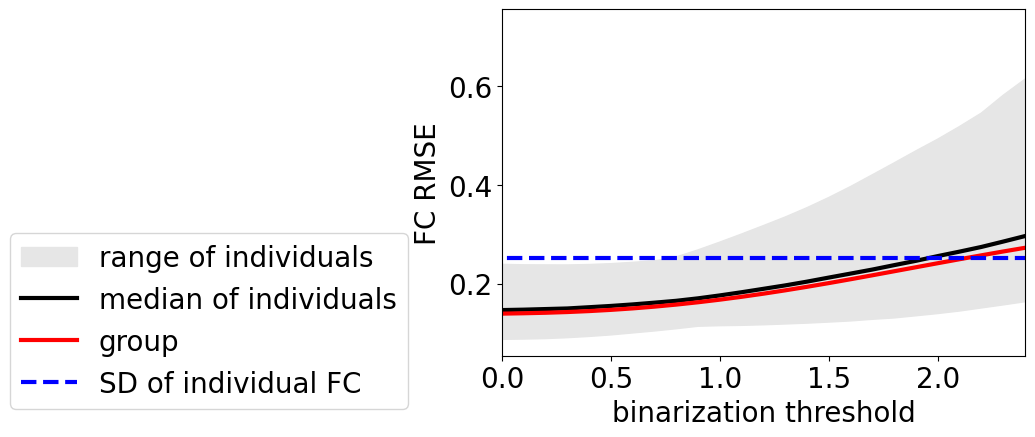

In [32]:
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(6.75, 4.5) )
thresholds_np = depytorch(thresholds)
subject_dim = -1
line_width = 3.0
min_fc_rmse = depytorch( torch.min(fc_rmse, dim=subject_dim).values )
max_fc_rmse = depytorch( torch.max(fc_rmse, dim=subject_dim).values )
median_fc_rmse = depytorch( torch.median(fc_rmse, dim=subject_dim).values )
group_fc_rmse_np = depytorch(group_fc_rmse)
data_fc_std_horizontal_np = depytorch(data_fc_std_horizontal)
axs.fill_between(thresholds_np, min_fc_rmse, max_fc_rmse, color=[0.9, 0.9, 0.9], label='range of individuals')
# axs.plot(thresholds_np, min_fc_rmse, color='black', linestyle='--', linewidth=line_width)
# axs.plot(thresholds_np, max_fc_rmse, color='black', linestyle='--', linewidth=line_width)
axs.plot(thresholds_np, median_fc_rmse, color='black', label='median of individuals', linewidth=line_width)
axs.plot(thresholds_np, group_fc_rmse_np, color='red', label='group', linewidth=line_width)
axs.plot(thresholds_np, data_fc_std_horizontal_np, color='blue', label='SD of individual FC', linewidth=line_width, linestyle='--')
axs.set_xlabel('binarization threshold')
axs.set_ylabel('FC RMSE')
axs.set_xlim([0, 2.4])
# axs.set_ylim([-0.1, 1.1])
axs.legend( loc='center', bbox_to_anchor=(-0.56, 0.10) )
plt.show()